In [43]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import os

In [159]:
def get_df():
    return pd.read_csv("../data/rebid_output.csv")
get_df()
df.head()

,externaltransactionId,internalTransactionId,gasFee,timestamp,blockId
0,cebd3f73a6869df39cfb03038fada6a4ff70af798223d4...,7eee705b7b2703ed8199b9ebca219afa44b57f63f2ac62...,17001,2024-01-13 10:48:19.242125056,825611
1,cebd3f73a6869df39cfb03038fada6a4ff70af798223d4...,7eee705b7b2703ed8199b9ebca219afa44b57f63f2ac62...,18265,2024-01-13 10:49:37.900187904,825611
2,cebd3f73a6869df39cfb03038fada6a4ff70af798223d4...,7eee705b7b2703ed8199b9ebca219afa44b57f63f2ac62...,18996,2024-01-13 10:49:37.926140160,825611
3,cebd3f73a6869df39cfb03038fada6a4ff70af798223d4...,7eee705b7b2703ed8199b9ebca219afa44b57f63f2ac62...,19558,2024-01-13 10:49:38.375032064,825611
4,cebd3f73a6869df39cfb03038fada6a4ff70af798223d4...,7eee705b7b2703ed8199b9ebca219afa44b57f63f2ac62...,20148,2024-01-13 11:07:25.259067136,825611


In [19]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')

In [28]:
unique_external = df['externaltransactionId'].nunique()
unique_internal = df['internalTransactionId'].nunique()
print(unique_external)
print(unique_internal)
unique_external == unique_internal 

2893
2705


False

In [32]:
top_transactions = df['internalTransactionId'].value_counts().head(3).index.tolist()

In [33]:
top_transactions

['429099ffb1368dd32116c803e26ef25de29c7b2e3755922fc0d13fd6c1869d74',
 '20e08a9398dde2bc614da2ab882d921840c15a88ccbcc60505c9151950b75cd2',
 'f21f480492c023a98fbabde1bc79923723cea3c76eb219c84ca6c34db7d7ed10']

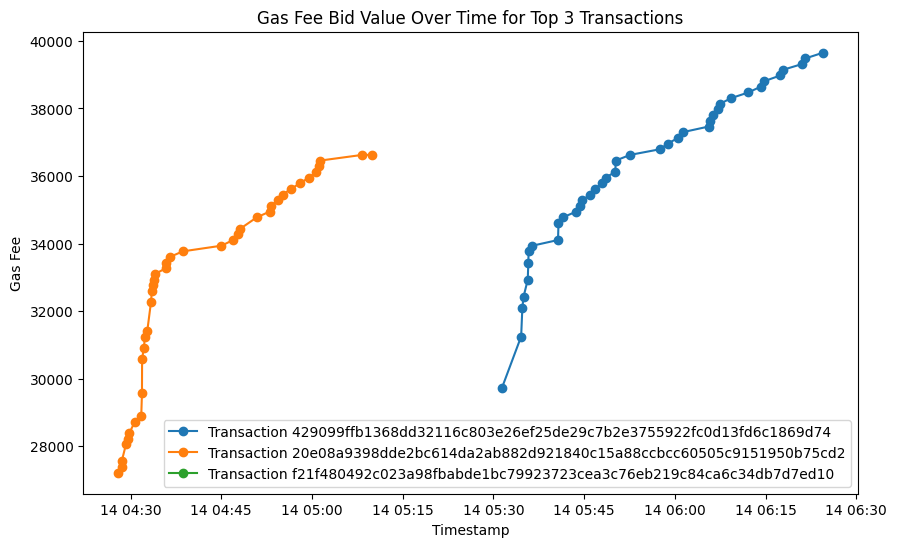

In [36]:
top_df = df[df['internalTransactionId'].isin(top_transactions[:2])]

fig, ax = plt.subplots(figsize=(10, 6))

for tx_id in top_transactions:
    subset = top_df[top_df['internalTransactionId'] == tx_id]
    ax.plot(subset['timestamp'], subset['gasFee'], marker='o', label=f'Transaction {tx_id}')

ax.set_xlabel('Timestamp')
ax.set_ylabel('Gas Fee')
ax.set_title('Gas Fee Bid Value Over Time for Top 3 Transactions')
ax.legend()

plt.show()

/var/folders/0t/bxhw013j4cg5h_7986f_s0rm0000gn/T/ipykernel_16320/2607454553.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = get_cmap('viridis', num_unique_transactions)


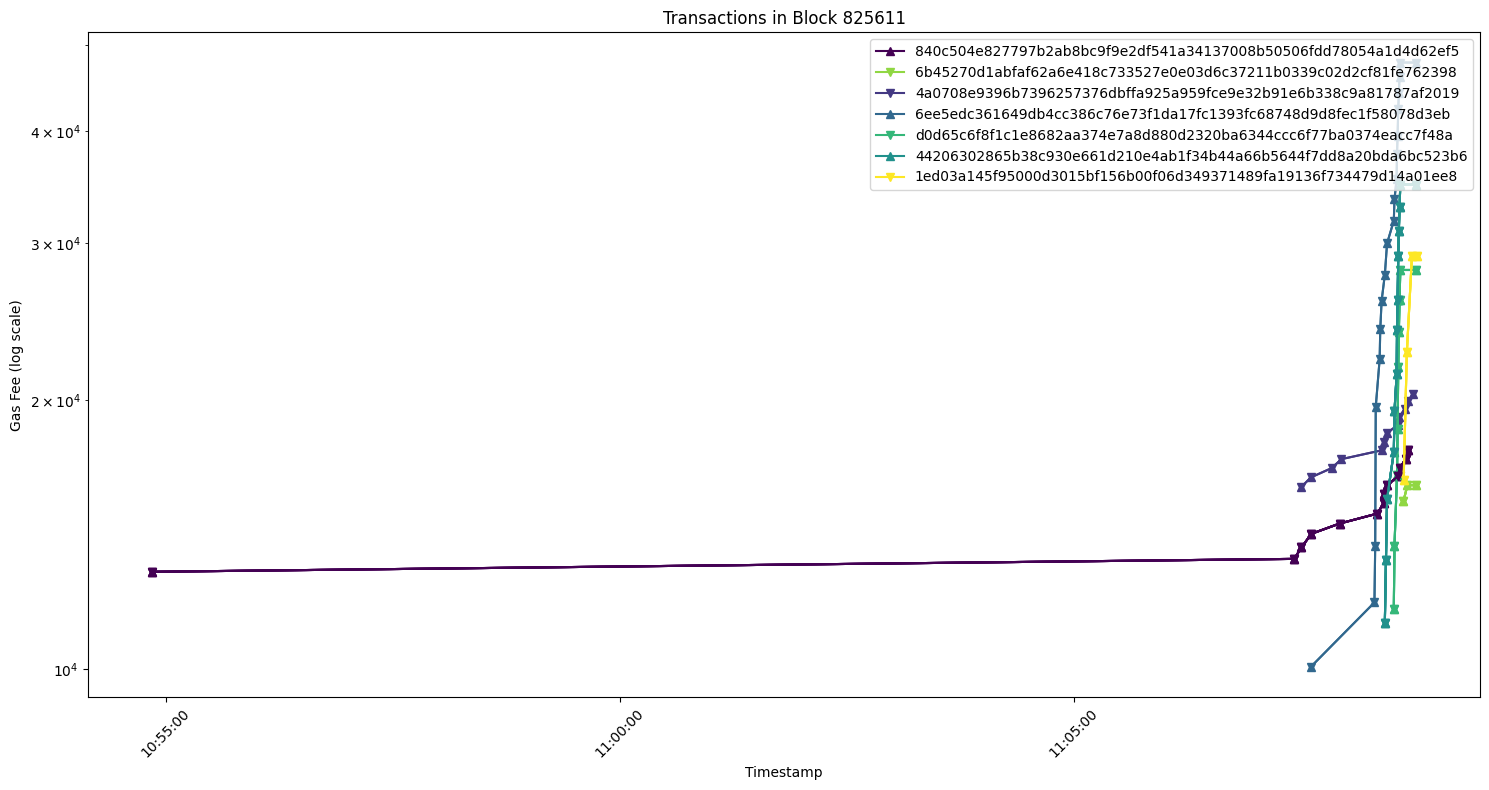

In [164]:
from matplotlib.cm import get_cmap
# We consider competing transactions to be those within the same block with similar gas fees.
# First, we define a threshold for what we consider 'roughly similar' fees. This is somewhat arbitrary and might need adjustment.
fee_threshold = 1  # example threshold

# Find transactions within the same block that have gas fees within the threshold of each other
competing_transactions = []

for idx, block in enumerate(df['blockId'].unique()):
    block_df = df[df['blockId'] == block]
    for index, row in block_df.iterrows():
        # Find transactions in the same block with similar fees
        similar_fees_df = block_df[(block_df['gasFee'] >= row['gasFee'] - fee_threshold) &
                                   (block_df['gasFee'] <= row['gasFee'] + fee_threshold) &
                                   (block_df['externaltransactionId'] != row['externaltransactionId'])]
        for idx, r in similar_fees_df.iterrows():
            competing_transactions.append((row['externaltransactionId'], r['externaltransactionId'], block))
    if competing_transactions:
        break

# Convert to DataFrame for easier handling
competing_transactions_df = pd.DataFrame(competing_transactions, columns=['Transaction1', 'Transaction2', 'BlockId'])

use_log_scale = True

for ax, block in zip(axs, competing_transactions_df['BlockId'].unique()):
    block_competing_df = competing_transactions_df[competing_transactions_df['BlockId'] == block]
    block_df = df[df['blockId'] == block]

    # Define a colormap
    num_unique_transactions = len(pd.unique(block_competing_df[['Transaction1', 'Transaction2']].values.ravel('K')))
    color_map = get_cmap('viridis', num_unique_transactions)
    
    # Create a dictionary to map transaction ID to color
    transaction_ids = pd.unique(block_competing_df[['Transaction1', 'Transaction2']].values.ravel('K'))
    color_dict = {trans_id: color_map(i) for i, trans_id in enumerate(transaction_ids)}

    
    # Calculate the timestamps at which the first 20% and the remaining 80% of updates occur
    update_timestamps = block_df['timestamp'].sort_values()
    split_index = int(len(update_timestamps) * 0.2)
    first_20_timestamp = update_timestamps.iloc[split_index]
    
    # Now plot in two separate subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 25), gridspec_kw={'height_ratios':[6, 6]})
    
    # First 20% plot
    early_df = block_df[block_df['timestamp'] <= first_20_timestamp]
    for _, row in block_competing_df.iterrows():
        trans1_color = color_dict[row['Transaction1']]
        trans2_color = color_dict[row['Transaction2']]
        trans1_df = early_df[early_df['externaltransactionId'] == row['Transaction1']]
        trans2_df = early_df[early_df['externaltransactionId'] == row['Transaction2']]
        ax1.plot(trans1_df['timestamp'], trans1_df['gasFee'], color=trans1_color, marker='^', label=f'{row["Transaction1"]}')
        ax1.plot(trans2_df['timestamp'], trans2_df['gasFee'], color=trans2_color, marker='v', label=f'{row["Transaction2"]}')
    
    # Remaining 80% plot
    late_df = block_df[block_df['timestamp'] > first_20_timestamp]
    for _, row in block_competing_df.iterrows():
        trans1_color = color_dict[row['Transaction1']]
        trans2_color = color_dict[row['Transaction2']]
        trans1_df = late_df[late_df['externaltransactionId'] == row['Transaction1']]
        trans2_df = late_df[late_df['externaltransactionId'] == row['Transaction2']]
        ax2.plot(trans1_df['timestamp'], trans1_df['gasFee'], color=trans1_color, marker='^', label=f'{row["Transaction1"]}')
        ax2.plot(trans2_df['timestamp'], trans2_df['gasFee'], color=trans2_color, marker='v', label=f'{row["Transaction2"]}')
    
    # Set the common attributes (labels, titles, etc.)
    for ax in (ax1, ax2):
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H%M%S'))
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Gas Fee (log scale)' if use_log_scale else 'Gas Fee')
        ax.tick_params(axis='x', rotation=45)
        # Set log scale if needed
        # if use_log_scale:
        #     ax.set_yscale('log')
    ax1.set_title(f'First 20% of Updates in Block {block+1}')
    ax2.set_title(f'Remaining 80% of Updates in Block {block}')

    legend_dict = {}

    for ax in (ax1, ax2):
        for handle, label in zip(*ax.get_legend_handles_labels()):
            legend_dict[label] = handle  # This ensures that each label has the correct handle
    
    # Extract handles and labels, preserving the order
    labels, handles = zip(*legend_dict.items())

    print(handles, labels)
    
    # Adding the legend below the plots in their own subplot
    # This time we're directly using the handles and labels extracted from the plots
    fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))

# Adjust the layout to make room for the legend
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [181]:
import ipywidgets as widgets
from IPython.display import display

def plot_block(block):
    df = get_block_df(block)
    plot_specific_block(df)

def get_block_df(block, fee_threshold: int = 1):
    competing_transactions = []
    block_df = df[df['blockId'] == block]
    for index, row in block_df.iterrows():
        # Find transactions in the same block with similar fees
        similar_fees_df = block_df[(block_df['gasFee'] >= row['gasFee'] - fee_threshold) &
                                   (block_df['gasFee'] <= row['gasFee'] + fee_threshold) &
                                   (block_df['externaltransactionId'] != row['externaltransactionId'])]
        for idx, r in similar_fees_df.iterrows():
            competing_transactions.append((row['externaltransactionId'], r['externaltransactionId'], block))
    return pd.DataFrame(competing_transactions, columns=['Transaction1', 'Transaction2', 'BlockId'])

def plot_specific_block(competing_transactions_df, use_log_scale = True):  
    for block in competing_transactions_df['BlockId'].unique():
        block_competing_df = competing_transactions_df[competing_transactions_df['BlockId'] == block]
        block_df = df[df['blockId'] == block]
    
        # Define a colormap
        num_unique_transactions = len(pd.unique(block_competing_df[['Transaction1', 'Transaction2']].values.ravel('K')))
        color_map = get_cmap('viridis', num_unique_transactions)
    
        # Create a dictionary to map transaction ID to color
        transaction_ids = pd.unique(block_competing_df[['Transaction1', 'Transaction2']].values.ravel('K'))
        color_dict = {trans_id: color_map(i) for i, trans_id in enumerate(transaction_ids)}
    
        # Create the plot
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Plot each transaction
        for _, row in block_competing_df.iterrows():
            trans1_color = color_dict[row['Transaction1']]
            trans2_color = color_dict[row['Transaction2']]
            trans1_df = block_df[block_df['externaltransactionId'] == row['Transaction1']]
            trans2_df = block_df[block_df['externaltransactionId'] == row['Transaction2']]
            ax.plot(trans1_df['timestamp'], trans1_df['gasFee'], color=trans1_color, marker='^', label=row['Transaction1'])
            ax.plot(trans2_df['timestamp'], trans2_df['gasFee'], color=trans2_color, marker='v', label=row['Transaction2'])
    
        # Set axis labels and title
        ax.set_xlabel('Timestamp')
        ax.set_ylabel('Gas Fee (log scale)' if use_log_scale else 'Gas Fee')
        ax.set_title(f'Transactions in Block {block}')
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
        ax.tick_params(axis='x', rotation=45)
    
        # Set log scale if needed
        if use_log_scale:
            ax.set_yscale('log')
    
        # Handle legend
        handles, labels = ax.get_legend_handles_labels()
        unique_labels = []
        unique_handles = []
        for handle, label in zip(handles, labels):
            if label not in unique_labels:
                unique_labels.append(label)
                unique_handles.append(handle)
        print(unique_labels)
    try:
        fig.legend(unique_handles, unique_labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05))
        plt.tight_layout()
        plt.show()
    except UnboundLocalError:
        print("There are no txs to plot")

In [182]:
block_selector = widgets.Select(options=df['blockId'].unique())
widgets.interactive(plot_block, block=block_selector)

interactive(children=(Select(description='block', options=(825611, 825612, 825613, 825614, 825615, 825616, 825…

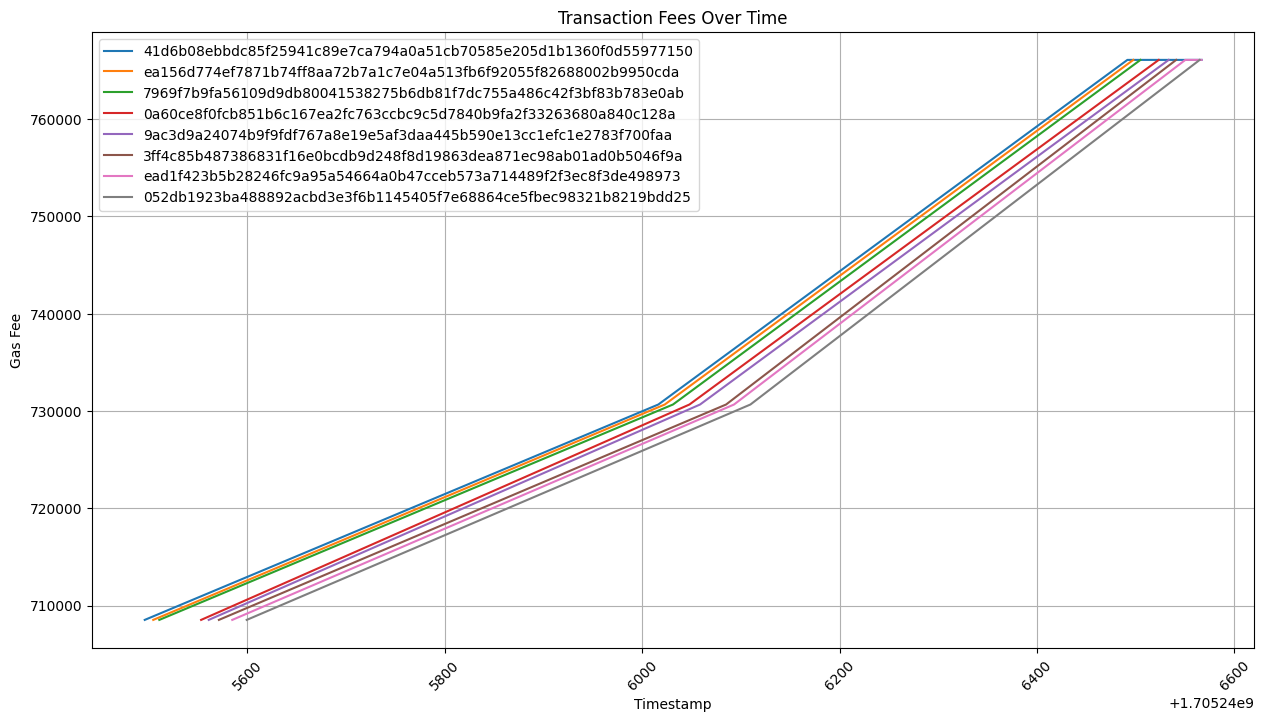

In [192]:
def plot_transaction_fees_over_time(transactions):
    df = get_df()

    # Filter for the specified transactions
    filtered_df = df[df['externaltransactionId'].isin(transactions)]

    if filtered_df.empty:
        print("No transactions found for the given IDs")
        return

    # Plotting
    plt.figure(figsize=(15, 8))
    for trans_id in transactions:
        trans_df = filtered_df[filtered_df['externaltransactionId'] == trans_id]
        if not trans_df.empty:
            plt.plot(trans_df['timestamp'], trans_df['gasFee'], label=trans_id)

    plt.xlabel('Timestamp')
    plt.ylabel('Gas Fee')
    plt.title('Transaction Fees Over Time')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()
to_plot = ['41d6b08ebbdc85f25941c89e7ca794a0a51cb70585e205d1b1360f0d55977150', 'ea156d774ef7871b74ff8aa72b7a1c7e04a513fb6f92055f82688002b9950cda', '7969f7b9fa56109d9db80041538275b6db81f7dc755a486c42f3bf83b783e0ab', '0a60ce8f0fcb851b6c167ea2fc763ccbc9c5d7840b9fa2f33263680a840c128a', '9ac3d9a24074b9f9fdf767a8e19e5af3daa445b590e13cc1efc1e2783f700faa', '3ff4c85b487386831f16e0bcdb9d248f8d19863dea871ec98ab01ad0b5046f9a', 'ead1f423b5b28246fc9a95a54664a0b47cceb573a714489f2f3ec8f3de498973', '052db1923ba488892acbd3e3f6b1145405f7e68864ce5fbec98321b8219bdd25']

plot_transaction_fees_over_time(to_plot)

In [188]:
tx to understand:
https://mempool.space/tx/0dbca77f13dd9243c04e550432f9e12d227e5dd74e087f9408b86b57ae90fda1
https://mempool.space/tx/b8a7433c8622c16c982a5fe9e198d7968fbdd57ad63f78a6b4caf8d916557fef

https://mempool.space/tx/b7deac15559aaf5cd18bf3a7660a125e2f43ff2a38d94c11d83420dd62b22f49
https://mempool.space/tx/c1f7dc98b1b8e40905644e86fea9444f9a07b826fd66c1621a329bd1c4d8ed2a

https://mempool.space/tx/65412202724f566bdbe667f761cbb44b0e2f25eefdb0890a254d6f4d4f6099c4
https://mempool.space/tx/7acd3550f16cd8d5ced740443f20da6b0f649c14618ac1c127bcba3fd49f88b4

SyntaxError: invalid syntax (1422231304.py, line 1)